# 1. Library prep

In [148]:
import pandas as pd
import numpy as np

import seaborn as sns

import eda

# NLP stuff
# TODO: remove unnecessary imports
from nltk import ngrams, pos_tag
from nltk.corpus import names, stopwords, wordnet as wn
from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer, RegexpTokenizer, MWETokenizer
from nltk.cluster import cosine_distance, euclidean_distance
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.chunk import ne_chunk

# other string processing
import re
import string

# classifiers
from sklearn.ensemble import RandomForestClassifier, BaseEnsemble
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB

# clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration

# model selection and metric helpers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.metrics import classification_report, roc_curve, fbeta_score, log_loss, roc_auc_score, euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

Run this if NLTK hasn't been set up locally

In [67]:
#import nltk
#nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# 2. Data loading and initial inspection

From the README:

- Column 1: the ID of the statement ([ID].json).
- Column 2: the label.
- Column 3: the statement.
- Column 4: the subject(s).
- Column 5: the speaker.
- Column 6: the speaker's job title.
- Column 7: the state info.
- Column 8: the party affiliation.
- Column 9-13: the total credit history count, including the current statement.
  - 9: barely true counts.
  - 10: false counts.
  - 11: half true counts.
  - 12: mostly true counts.
  - 13: pants on fire counts.
- Column 14: the context (venue / location of the speech or statement).

In [151]:
# read the LIAR dataset

liar_credit_hist_headers = ['speaker_bt', 'speaker_f', 'speaker_ht', 'speaker_mt', 'speaker_pof']
liar_speaker_headers = ['speaker', 'speaker_job', 'speaker_us_state', 'speaker_affiliation'] + liar_credit_hist_headers
liar_column_headers = ['id', 'label', 'statement', 'subjects']  + liar_speaker_headers + ['context']

# read the pre-prepared training, validation and test sets

liar_train = pd.read_csv("./data/liar_dataset/train.tsv", sep='\t', names=liar_column_headers)
liar_valid = pd.read_csv("./data/liar_dataset/valid.tsv", sep='\t', names=liar_column_headers)
liar_test = pd.read_csv("./data/liar_dataset/test.tsv", sep='\t', names=liar_column_headers)

# combine the pre-prepared training and validation sets; we want to do our own 5-fold cv

liar_train = liar_train.append(liar_valid)

liar_train

,id,label,statement,subjects,speaker,speaker_job,speaker_us_state,speaker_affiliation,speaker_bt,speaker_f,speaker_ht,speaker_mt,speaker_pof,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,3419.json,half-true,"For the first time in more than a decade, impo...","energy,oil-spill,trade",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a press conference
1280,12548.json,mostly-true,Says Donald Trump has bankrupted his companies...,candidates-biography,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,a speech on the economy
1281,401.json,true,"John McCain and George Bush have ""absolutely n...",health-care,campaign-defend-america,NaN,"Washington, D.C.",none,0.0,1.0,0.0,2.0,0.0,a television ad
1282,1055.json,false,A new poll shows 62 percent support the presid...,health-care,americans-united-change,NaN,NaN,none,1.0,4.0,4.0,1.0,0.0,an Internet ad.


In [7]:
liar_train.iloc[0]['statement']

'Says the Annies List political group supports third-trimester abortions on demand.'

Plot the truth values of the dataset

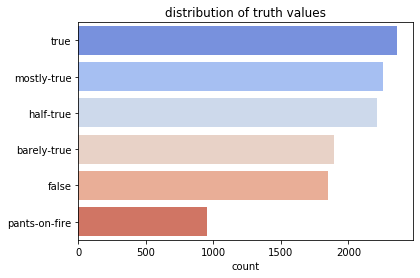

In [65]:
liar_label_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-on-fire']

sns.barplot(y=liar_label_order, x=liar_train['label'].value_counts(), palette='coolwarm').set(title='distribution of truth values', xlabel='count')
plt.tight_layout()
plt.savefig('./image/liar_truthvals_dist.png');

In [63]:
liar_train['speaker_affiliation'].value_counts()

republican                      5094
democrat                        3731
none                            1967
organization                     237
independent                      166
newsmaker                         63
libertarian                       46
activist                          43
journalist                        40
columnist                         37
talk-show-host                    29
state-official                    20
labor-leader                      15
tea-party-member                  10
business-leader                   10
education-official                 3
green                              3
constitution-party                 2
government-body                    1
Moderate                           1
liberal-party-canada               1
county-commissioner                1
democratic-farmer-labor            1
ocean-state-tea-party-action       1
Name: speaker_affiliation, dtype: int64

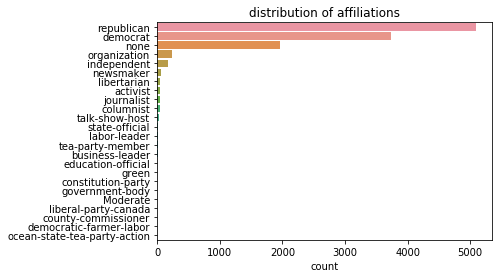

In [66]:
sns.barplot(y=liar_train['speaker_affiliation'].value_counts().index, x=liar_train['speaker_affiliation'].value_counts()).set(title='distribution of affiliations', xlabel='count')
plt.tight_layout()
plt.savefig('./image/liar_affiliations_dist.png');

In [121]:
liar_speakers_full = liar_train[liar_speaker_headers]

liar_speakers = liar_speakers_full.drop_duplicates().sort_values(by='speaker')
#liar_speakers['count_in_set'] = liar_speakers_full.groupby(liar_speaker_headers, as_index=False).size().values

liar_speakers['speaker'].value_counts()

#liar_speakers_full.groupby('speaker', as_index=False).size()

robert-puente      2
kasim-reed         2
danny-tarkanian    2
jeff-dickerson     1
paul-bedard        1
                  ..
roy-blunt          1
cynthia-lummis     1
armond-budish      1
reed-gusciora      1
greg-steube        1
Name: speaker, Length: 3126, dtype: int64

Inconsistencies are due to the merging of the default train and validation sets

In [129]:
liar_train[liar_train['speaker']=='kasim-reed']

,id,label,statement,subjects,speaker,speaker_job,speaker_us_state,speaker_affiliation,speaker_bt,speaker_f,speaker_ht,speaker_mt,speaker_pof,context
559,4659.json,true,On letting Occupy Atlanta protesters stay in W...,"occupy-wall-street,public-safety",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,statements to the public
1587,7862.json,mostly-true,My office is about a 300-step walk to the gove...,"city-government,economy",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,leadership forum
1901,9749.json,true,The minimum number of infrastructure (needs) i...,city-government,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,press conference
2073,8186.json,true,State law says that once the state appraises a...,"city-government,corrections-and-updates,sports",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,an interview
3233,8898.json,mostly-true,"Right now, we only keep 50 percent of Georgia ...","economy,education,jobs",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,a speech
3483,8171.json,mostly-true,"Atlanta now has as many visitors as Las Vegas,...",tourism,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,a radio interview
4279,8938.json,true,The annual gross domestic product of metro Atl...,economy,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,a speech
4291,7228.json,false,On same-sex marriage,"civil-rights,gays-and-lesbians,marriage",kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,NaN
5002,6038.json,pants-fire,The new Hartsfield-Jackson international termi...,transportation,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,press conference
5410,5252.json,half-true,We have cut crime across every single zone in ...,crime,kasim-reed,NaN,NaN,democrat,1.0,0.0,5.0,7.0,1.0,the State of the City address


We don't need the counts for individual speaker truth values, especially when there's no date attached

TODO: pull from main API to extract date of news?

Need to convert subjects column into a list

In [167]:
liar_train['subject_list'] = liar_train['subjects'].apply(lambda s: str(s).split(','))
liar_test['subject_list'] = liar_test['subjects'].apply(lambda s: str(s).split(','))

liar_train_subj_dummies = eda.createdummy_from_listentries(liar_train, 'subject_list')

liar_train_subj_dummies

,Alcohol,abc-news-week,abortion,afghanistan,after-the-fact,agriculture,animals,autism,bankruptcy,baseball,...,unions,urban,veterans,voting-record,water,wealth,weather,welfare,women,workers
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
LIAR_SUBJ_THRESHOLD = 100

liar_train_subj_summary = pd.DataFrame(data=liar_train_subj_dummies.sum(), columns=['count']).sort_values(by='count', ascending=False)
liar_train_subj_summary['is_minor'] = liar_train_subj_summary['count'] < LIAR_SUBJ_THRESHOLD

liar_train_subj_summary

In [ ]:
fig, ax = plt.subplot(figsize=(5,10))

sns.barplot(x=liar_train_subj_summary.head(50)['count'], y=liar_train_subj_summary.head(50).index, ax=ax, hue='is_minor').set(title='top 50 subjects')
plt.axvline(LIAR_SUBJ_THRESHOLD, color='red', linestyle=':')
plt.text(LIAR_SUBJ_THRESHOLD, 0.2, " " + str(LIAR_SUBJ_THRESHOLD) + " entries", transform=ax.get_xaxis_transform())
plt.tight_layout()
plt.savefig('./image/liar_subj_dist_top50.png');

In [134]:
pd.get_dummies(liar_train, columns=['subjects'])

,id,label,statement,speaker,speaker_job,speaker_us_state,speaker_affiliation,speaker_bt,speaker_f,speaker_ht,...,subjects_voting-record,subjects_water,subjects_wealth,"subjects_wealth,workers",subjects_weather,subjects_welfare,"subjects_welfare,workers",subjects_women,"subjects_women,workers",subjects_workers
0,2635.json,false,Says the Annies List political group supports ...,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,10540.json,half-true,When did the decline of coal start? It started...,scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,...,0,0,0,0,0,0,0,0,0,0
3,1123.json,false,Health care reform legislation is likely to ma...,blog-posting,NaN,NaN,none,7.0,19.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,9028.json,half-true,The economic turnaround started at the end of ...,charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,3419.json,half-true,"For the first time in more than a decade, impo...",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,...,0,0,0,0,0,0,0,0,0,0
1280,12548.json,mostly-true,Says Donald Trump has bankrupted his companies...,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,...,0,0,0,0,0,0,0,0,0,0
1281,401.json,true,"John McCain and George Bush have ""absolutely n...",campaign-defend-america,NaN,"Washington, D.C.",none,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1282,1055.json,false,A new poll shows 62 percent support the presid...,americans-united-change,NaN,NaN,none,1.0,4.0,4.0,...,0,0,0,0,0,0,0,0,0,0
